<font size="+3"><strong>6.5. Small Business Owners in the United States🇺🇸</strong></font>

### Welcome to the Clustering Credit-Challenged Households Using SCF 2019 Data Project!

In the previous part, you built a model based on the highest-variance features of small business owners in the dataset and created several visualizations to communicate your results. In this part, you're going to combine all of these elements into a dynamic web application that will allow users to choose their own features, build a model, and evaluate its performance through a graphical user interface. In other words, you'll create a tool that will allow anyone to build a model without code. 

**2. Interactive Dash web:** You'll build a dash web by creating functions for each part of the model and use decorator to display it on your web.

`NOTE:` Each function have a docstring which will guide you what the function should contain.

In [5]:
# Import libraries 
import pandas as pd
import plotly.express as px

from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from dash import Dash, Input, Output, dcc, html

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Prepare Data

## Import

#### Task 6.5.1 
Create wrangle function using the docstring as a guide. Then use your function to read the file "SCFP2019.csv.gz" into a DataFrame. 

In [6]:
def wrangle(filepath):  
    """Read SCF data file into ``DataFrame``.

    Returns only small business owners whose income is less than $500_000.

    Parameters
    ----------
    filepath : str
        Location of CSV file.
    """

    # read the compressed csv into a dataframe
    df = pd.read_csv(filepath)

    mask = (df["HBUS"] == 1 ) & (df["INCOME"] < 5e5 )

    #  subset the dataframe
    df = df[mask]
    
    return df

In [7]:
df = wrangle("data/SCFP2019.csv.gz")

print("df type:", type(df))
print("df shape:", df.shape)
df.head()

df type: <class 'pandas.core.frame.DataFrame'>
df shape: (4161, 357)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
80,17,171,7802.265717,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
81,17,172,8247.536301,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
82,17,173,8169.562719,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
83,17,174,8087.704517,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
84,17,175,8276.510048,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4


# Build Dashboard

## Application Layout

#### Task 6.5.2 
Instantiate a Dash application and assign it to the variable name app.

In [8]:
app = Dash(__name__)

print("app type:", type(app))

app type: <class 'dash.dash.Dash'>


#### Task 6.5.3 
Start building the layout of your app by creating a Div object that has two child objects: an H1 header that reads "Small Business Owners" and an H2 header that reads "High Variance Features".

In [9]:
app.layout = html.Div(
    [
        # Application title
        html.H1("Small Business Owners"),
        # Bar chart elements
        html.H2("High Variance Features"),

        # Add bar chart
        dcc.Graph(id="bar-chart"),
        dcc.RadioItems(
            options=[
                {"label": "trimmed", "value":True},
                {"label": "not trimmed", "value": False}
            ],
            value=True,
            id="trim-button"
        ),
        html.H2("K-means Clustering"),
        html.H3("Number of clusters (k)"),
        dcc.Slider(min=2, max=12, step=1, value=2, id="k-slider"),
        html.Div(id="metrics"),
        # PCA scatter plot
        dcc.Graph(id="pca_scatter")
        
    ]
)

## Variance Bar Chart

#### Task 6.5.4 
Add a Graph object to your application's layout. Be sure to give it the id "bar-chart" 

Create a get_high_var_features function that returns the five highest-variance features in a DataFrame. Use the docstring for guidance. 

In [10]:
def get_high_var_features(trimmed=True, return_feat_names=True): 
    """Returns the five highest-variance features of ``df``.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    return_feat_names : bool, default=False
        If ``True``, returns feature names as a ``list``. If ``False``
        returns ``Series``, where index is feature names and values are
        variances.
    """

    # calculate the variance
    if trimmed:
        top_five_features = df.apply(trimmed_var).sort_values().tail(5)

    else:
        top_five_features = df.var().sort_values().tail(5)

    # Extract feature names
    if return_feat_names:
        top_five_features = top_five_features.index.tolist()
    
    return top_five_features

In [11]:
get_high_var_features(return_feat_names=False, trimmed=False)

KGTOTAL     7.454386e+13
NFIN        1.149004e+14
NHNFIN      1.196403e+14
NETWORTH    1.796109e+14
ASSET       1.928282e+14
dtype: float64

Now that you have the top five features, use a function to return them in a bar chart.

#### Task 6.5.5
Create a serve_bar_chart function that returns a plotly express bar chart of the five highest-variance features. You should use get_high_var_features as a helper function. Follow the docstring for guidance.

In [12]:
@app.callback(
    Output("bar-chart", "figure"), Input("trim-button", "value")
)

def serve_bar_chart(trimmed=True): 
    """Returns a horizontal bar chart of five highest-variance features.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.
    """

    # Get features
    top_five_feature = get_high_var_features(trimmed=trimmed, return_feat_names=False)

    # Build bar chart
    fig = px.bar(x=top_five_feature, y=top_five_feature.index, orientation="h")
    fig.update_layout(xaxis_title="Variance", yaxis_title="Feature")
    
    return fig

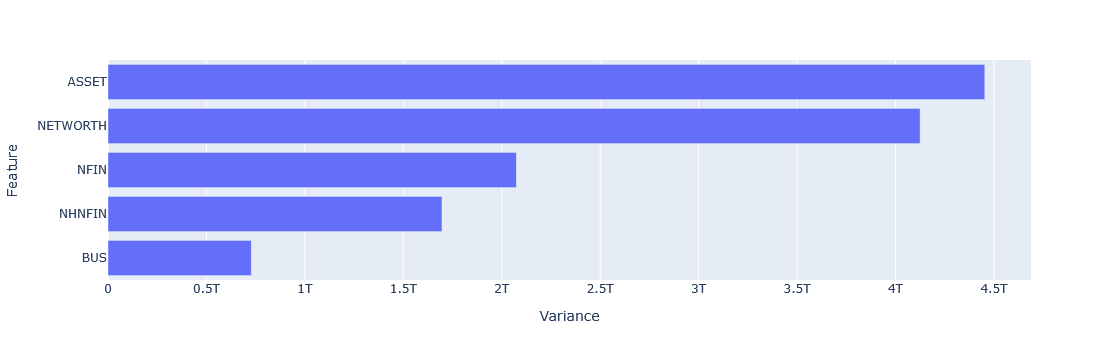

In [13]:
serve_bar_chart(trimmed=True)

#### Task 6.5.6


Add a radio button to your application's layout. It should have two options: "trimmed" (which carries the value True) and "not trimmed" (which carries the value False). Be sure to give it the id "trim-button".

#### Task 6.5.7 


Add a callback decorator to your serve_bar_chart function to display the bar chart on the web. The callback input should be the value returned by "trim-button", and the output should be directed to "bar-chart".

#### Task 6.5.8


## K-means Slider and Metrics

Okay, so now your app has a radio button, add a slider to your  help users see what it means for the number of clusters to change. The slider should range from `2` to `12`. Be sure to give it the id `"k-slider"`.

Again, add two text objects to your application's layout: an H2 header that reads "K-means Clustering" and an H3 header that reads "Number of Clusters (k)". 

#### Task 6.5.9
Add a Div object to your applications layout. Be sure to give it the id "metrics".

Create a `get_model_metrics` function that builds, trains, and evaluates `KMeans` model. Use the docstring for guidance. 

In [14]:
def get_model_metrics(trimmed=True, k=2, return_metrics=False):  
    """Build ``KMeans`` model based on five highest-variance features in ``df``.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.

    return_metrics : bool, default=False
        If ``False`` returns ``KMeans`` model. If ``True`` returns ``dict``
        with inertia and silhouette score.

    """
    # Get top five variance features
    features = get_high_var_features(trimmed=trimmed, return_feat_names=True)
    # Create feature matrix
    X = df[features]
    # Build model
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    model.fit(X)

    if return_metrics:
        # calculate inertia
        i = model.named_steps["kmeans"].inertia_
        # calculate silhouette score
        ss = silhouette_score(X, model.named_steps["kmeans"].labels_)
        # Put results into a dictionary
        metrics = {
            "inertia":round(i),
            "silhouette": round(ss, 3)
                  }
        return metrics
        
    
    return model

In [15]:
get_model_metrics(trimmed=True, k=4, return_metrics=True)

{'inertia': 2083, 'silhouette': np.float64(0.757)}

#### Task 6.5.10
Create a `serve_metrics` function. It should use your `get_model_metrics` to build and get the metrics for a model, and then return two objects: An `H3` header with the model's inertia and another `H3` header with the silhouette score.

Then add a callback decorator to your `serve_metrics` function. The callback inputs should be the values returned by `"trim-button"` and `"k-slider"`, and the output should be directed to `"metrics"`.

In [16]:
# update the layout with the function
@app.callback(
    Output("metrics", "children"),
    Input("trim-button", "value"),
    Input("k-slider", "value")
)

def serve_metrics(trimmed=True, k=2):  
    """Returns list of ``H3`` elements containing inertia and silhouette score
    for ``KMeans`` model.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.
    """
    # Get metrics
    metrics = get_model_metrics(trimmed=trimmed, k=k, return_metrics=True)

    # Add metrics to HTML elements
    text= [
        html.H3(f"Inertia: {metrics['inertia']}"),
        html.H3(f"Silhouette Score: {metrics['silhouette']}")
    ]
   
    return text

## PCA Scatter Plot

#### Task 6.5.11
Add a `Graph` object to your application's layout. Be sure to give it the id `"pca-scatter"`.

Create a function `get_pca_labels` that subsets a DataFrame to its five highest-variance features, reduces those features to two dimensions using `PCA`, and returns a new DataFrame with three columns: `"PC1"`, `"PC2"`, and `"labels"`. This last column should be the labels determined by a `KMeans` model. Refer to the docstring for guidance. 

In [17]:
def get_pca_labels(trimmed=True, k=2):  
    """
    ``KMeans`` labels.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.
    """
    # Get features
    features = get_high_var_features(trimmed=trimmed, return_feat_names=True)
    X = df[features]

    # Instantiate PCA
    transformer = PCA(n_components=2, random_state=42)

    # Transform the data
    X_t = transformer.fit_transform(X)
    X_pca = pd.DataFrame(X_t, columns=["PC1", "PC2"])

    # Add labels
    model = get_model_metrics(trimmed=trimmed, k=k, return_metrics=False)
    X_pca["labels"] = model.named_steps["kmeans"].labels_.astype(str)
    X_pca.sort_values("labels", inplace=True)
    
    return X_pca

In [18]:
get_pca_labels(trimmed=True, k=4).tail()

,PC1,PC2,labels
1228,6.417797e+07,9.677892e+06,3
3124,1.012503e+08,-8.286721e+07,3
3125,1.009272e+08,-8.294468e+07,3
1199,5.336054e+07,8.371079e+06,3
1322,5.864089e+07,1.015403e+07,3


#### Task 6.5.12
Create a function `serve_scatter_plot` that creates a 2D scatter plot of the data used to train a `KMeans` model, along with color-coded clusters. Use `get_pca_labels` as a helper. Refer to the docstring for guidance. 

Add a callback decorator to your `serve_scatter_plot` function. The callback inputs should be the values returned by `"trim-button"` and `"k-slider"`, and the output should be directed to `"pca-scatter"`.

In [19]:
@app.callback(
    Output("pca_scatter", "figure"),
    Input("trim-button", "value"),
    Input("k-slider", "value")
)

def serve_scatter_plot(trimmed=True, k=2):
    """Build 2D scatter plot of ``df`` with ``KMeans`` labels.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.
    """
    # plot pca scatter
    fig = px.scatter(
        data_frame=get_pca_labels(trimmed=trimmed, k=k),
        x="PC1",
        y="PC2",
        color="labels",
        title="PCA Representation of Clusters"
    )
    fig.update_layout(xaxis_title="PC1", yaxis_title="PC2", legend_title_text="Clusters")
    
    return fig

In [20]:
# serve_scatter_plot(trimmed=True, k=4)

Run this code below and click the link to display the application.

In [21]:
if __name__ == "__main__":
    app.run(debug=True, jupyter_mode="external")

Dash app running on http://127.0.0.1:8050/
